In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import os
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation , BatchNormalization

2023-11-05 21:04:18.159906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 21:04:18.291968: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 21:04:18.323257: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 21:04:18.868314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def train_val_generators(TRAINING_DIR, TEST_DIR):

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,      # Rotate images by up to 40 degrees
                                     width_shift_range=0.2,  # Shift width by up to 20%
                                     height_shift_range=0.2, # Shift height by up to 20%
                                     shear_range=0.2,        # Shear angle by up to 20%
                                     zoom_range=0.2,         # Zoom in/out by up to 20%
                                     horizontal_flip=True,   # Flip horizontally
                                     fill_mode='nearest')
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator(rescale=1/255)
  

  test_datagen = ImageDataGenerator(rescale=1/255, 
                                   validation_split=0.4)
  validation_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(299, 299),
                                                                subset='validation')
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=256,
                                                                class_mode='categorical',
                                                                target_size=(224, 224), 
                                                                subset='training')

  return train_generator, validation_generator, test_generator

In [3]:
train_generator, validation_generator, test_generator = train_val_generators('Chest_CTScan_dataset-main/train', 'Chest_CTScan_dataset-main/test')

Found 613 images belonging to 4 classes.
Found 125 images belonging to 4 classes.
Found 190 images belonging to 4 classes.


In [27]:
datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,      # Rotate images by up to 40 degrees
                                     width_shift_range=0.2,  # Shift width by up to 20%
                                     height_shift_range=0.2, # Shift height by up to 20%
                                     shear_range=0.2,        # Shear angle by up to 20%
                                     zoom_range=0.2,         # Zoom in/out by up to 20%
                                     horizontal_flip=True,   # Flip horizontally
                                     fill_mode='nearest')

In [31]:
augmented_images = datagen.flow_from_directory(
    'Chest_CTScan_dataset-main/train',
    target_size=(224, 224),  # Ubah ukuran gambar sesuai kebutuhan Anda
    batch_size=1,  # Menggunakan batch_size=1 agar setiap gambar diolah satu per satu
    save_to_dir='augmented/train_data',  # Direktori penyimpanan gambar hasil augmentasi
    save_prefix='aug',  # Awalan nama gambar hasil augmentasi
    save_format='jpeg'  # Format gambar yang dihasilkan
)

Found 613 images belonging to 4 classes.


In [32]:
for i in range(10):  # Ganti dengan jumlah gambar yang ingin Anda augmentasi
    batch = augmented_images.next()

In [4]:
def InceptionV4():

    input_layer = Input(shape=(224 , 224 , 3))

    x = stemBlock(prev_layer=input_layer)

    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)

    x = reduction_A_Block(prev_layer=x)

    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)

    x = reduction_B_Block(prev_layer= x)

    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(units = 1536, activation='relu') (x)
    x = Dropout(rate = 0.8) (x)
    x = Dense(units = 1000, activation='relu')(x)

    model = Model(inputs = input_layer , outputs = x , name ='Inception-V4')

    return model

In [5]:
def conv2d_with_Batch(prev_layer , nbr_kernels , filter_size , strides = (1,1) , padding = 'valid'):
    x = Conv2D(filters = nbr_kernels, kernel_size = filter_size, strides=strides , padding=padding) (prev_layer)
    x = BatchNormalization()(x)
    x = Activation(activation = 'relu') (x)
    return x

In [6]:
def stemBlock(prev_layer):
    x = conv2d_with_Batch(prev_layer, nbr_kernels = 32, filter_size = (3,3), strides = (2,2))
    x = conv2d_with_Batch(x, nbr_kernels = 32, filter_size = (3,3))
    x = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (3,3))

    x_1 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (3,3), strides = (2,2) )
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)

    x = concatenate([x_1 , x_2], axis = 3)

    x_1 = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (1,7) , padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (7,1), padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 96, filter_size = (3,3))

    x_2 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (1,1))
    x_2 = conv2d_with_Batch(x_2, nbr_kernels = 96, filter_size = (3,3))

    x = concatenate([x_1 , x_2], axis = 3)

    x_1 = conv2d_with_Batch(x, nbr_kernels = 192, filter_size = (3,3) , strides=2)
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)

    x = concatenate([x_1 , x_2], axis = 3)

    return x

In [7]:
def reduction_A_Block(prev_layer) :
    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (3,3) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,3) , strides=(2,2))

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (3,3) , strides=(2,2))

    x_3 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)

    x = concatenate([x_1 , x_2 , x_3], axis = 3)

    return x

In [8]:
def reduction_B_Block(prev_layer):
    x_1 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 192, filter_size = (3,3) , strides=(2,2) )

    x_3 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1) )
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = (1,7) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (7,1) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (3,3) , strides=(2,2))

    x = concatenate([x_1 , x_2 , x_3], axis = 3)
    return x

In [9]:
def InceptionBlock_A(prev_layer): #I'm Here

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1), padding='same' )
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1) , padding='same')

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 96, filter_size = (3,3) , padding='same')

    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 96, filter_size = (1,1) , padding='same')

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 96, filter_size = (1,1))

    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)

    return output

In [10]:
def InceptionBlock_B(prev_layer):

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 192, filter_size = (7,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (7,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (1,7), padding='same')

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (7,1), padding='same')

    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 128, filter_size = (1,1))

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))

    output = concatenate([x_1 , x_2 ,x_3, x_4], axis = 3)
    return output

In [11]:
def InceptionBlock_C(prev_layer):

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 448, filter_size = (3,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 512, filter_size = (1,3) , padding='same')
    x_1_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_1_2 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_1 = concatenate([x_1_1 , x_1_2], axis = 3)

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_2_1 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_2_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_2 = concatenate([x_2_1 , x_2_2], axis = 3)

    x_3 = MaxPool2D(pool_size=(3,3),strides = 1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = 3  , padding='same')

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1))

    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)

    return output

In [12]:
model = InceptionV4()

# Custom Last Stage
x = model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=model.input, outputs=predictions)

# Compile
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

2023-11-05 21:04:34.557576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-05 21:04:34.557616: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-05 21:04:34.558169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
filepath = 'models/PCD-test-aug.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    verbose=1,
    mode='max'
)
callbacksList = [modelCheckpoint, earlyStopping]
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.7438 - accuracy: 0.3883
Epoch 1: val_accuracy improved from -inf to 0.16800, saving model to models/PCD-test-aug.h5
20/20 [==============================] - 47s 2s/step - loss: 1.7438 - accuracy: 0.3883 - val_loss: 8.7109 - val_accuracy: 0.1680
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.6950 - accuracy: 0.4372
Epoch 2: val_accuracy improved from 0.16800 to 0.28800, saving model to models/PCD-test-aug.h5
20/20 [==============================] - 28s 1s/step - loss: 1.6950 - accuracy: 0.4372 - val_loss: 1.3405 - val_accuracy: 0.2880
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.7570 - accuracy: 0.3377
Epoch 3: val_accuracy did not improve from 0.28800
20/20 [==============================] - 26s 1s/step - loss: 1.7570 - accuracy: 0.3377 - val_loss: 1.3443 - val_accuracy: 0.2880
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 1.4464 - accuracy: 0.

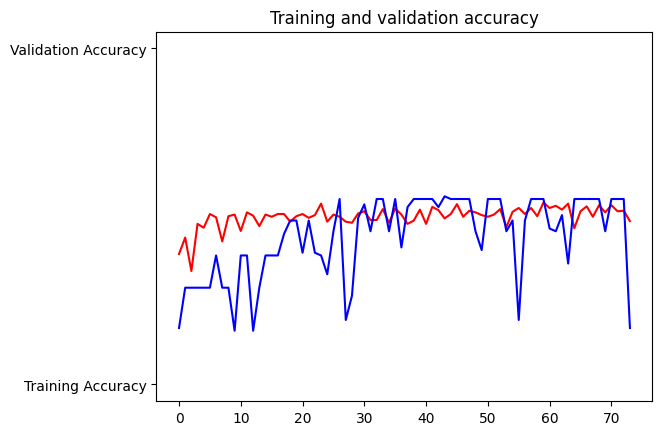

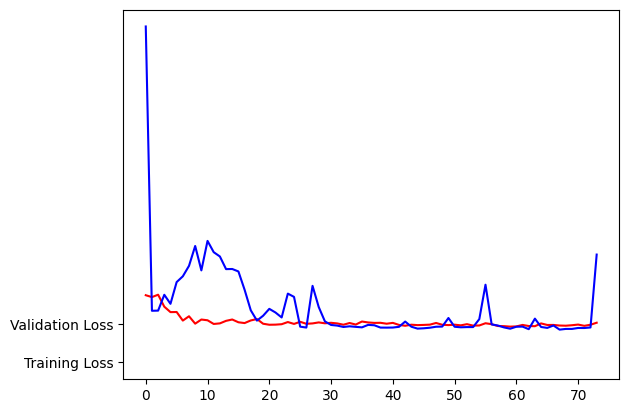

In [14]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [15]:
load_model = tf.keras.models.load_model('models/PCD-test-aug.h5')

In [16]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  190  y:  190


In [17]:
pred = load_model.predict(x)

y_test = []
for i in pred:
    y_test.append(np.argmax(i))

y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

6/6 [==============================] - 5s 427ms/step


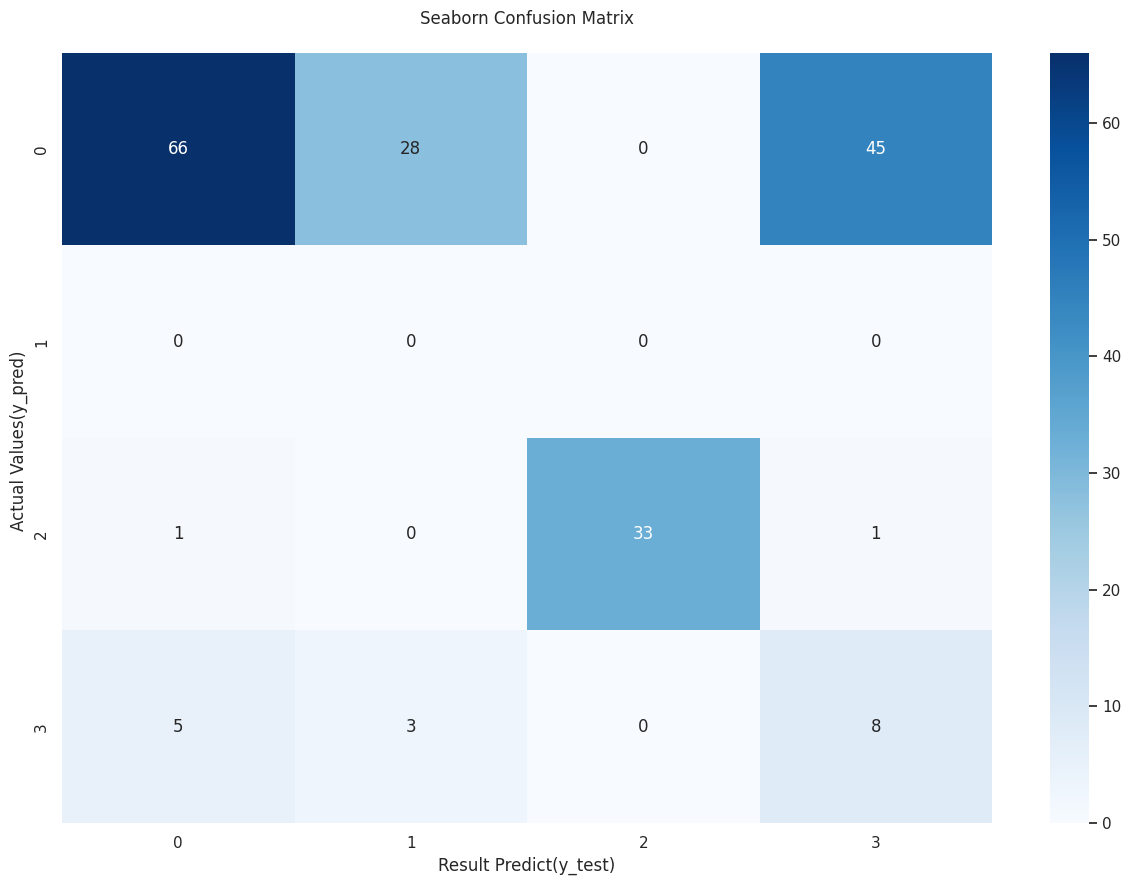

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ');

In [19]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.47      0.63       139
           1       0.00      0.00      0.00         0
           2       1.00      0.94      0.97        35
           3       0.15      0.50      0.23        16

    accuracy                           0.56       190
   macro avg       0.52      0.48      0.46       190
weighted avg       0.87      0.56      0.66       190



/home/dajuma/anaconda3/envs/myenv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dajuma/anaconda3/envs/myenv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

precision2 = precision_score(y_test, y_pred, average='micro')
recall2 = recall_score(y_test, y_pred, average='micro')
f1score2 = f1_score(y_test, y_pred, average='micro')

print(f"Precision = {precision2}")
print(f"Recall = {recall2}")
print(f"F1 Score = {f1score2}")

Precision = 0.5631578947368421
Recall = 0.5631578947368421
F1 Score = 0.5631578947368421
